# VolPy pipeline for processing voltage imaging data 
The processing pipeline includes motion correction, memory mapping, segmentation, denoising and source extraction. The demo shows how to construct the params, MotionCorrect and VOLPY objects and call the relevant functions. 
Dataset courtesy of Karel Svoboda Lab (Janelia Research Campus).

In [1]:
import os
import cv2
import glob
import logging
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import h5py
import imageio
from IPython.display import HTML, display, clear_output

from base64 import b64encode

try:
    cv2.setNumThreads(0)
except:
    pass

try:
    if __IPYTHON__:
        # this is used for debugging purposes only. allows to reload classes
        # when changed
        get_ipython().magic('load_ext autoreload')
        get_ipython().magic('autoreload 2')
except NameError:
    pass

import caiman as cm
from caiman.motion_correction import MotionCorrect
from caiman.utils.utils import download_demo, download_model
from caiman.source_extraction.volpy import utils
from caiman.source_extraction.volpy.volparams import volparams
from caiman.source_extraction.volpy.volpy import VOLPY
from caiman.source_extraction.volpy.mrcnn import visualize, neurons
import caiman.source_extraction.volpy.mrcnn.model as modellib
from caiman.summary_images import local_correlations_movie_offline
from caiman.summary_images import mean_image
from caiman.paths import caiman_datadir

# Set up the logger (optional); change this if you like.
# You can log to a file using the filename parameter, or make the output more
# or less verbose by setting level to logging.DEBUG, logging.INFO,
# logging.WARNING, or logging.ERROR
logging.basicConfig(format=
                    "%(relativeCreated)12d [%(filename)s:%(funcName)20s():%(lineno)s]" \
                    "[%(process)d] %(message)s",
                    level=logging.INFO)

/tmp/ipykernel_31434/4062216306.py:23: DeprecationWarning: `magic(...)` is deprecated since IPython 0.13 (warning added in 8.1), use run_line_magic(magic_name, parameter_s).
  get_ipython().magic('load_ext autoreload')
/tmp/ipykernel_31434/4062216306.py:24: DeprecationWarning: `magic(...)` is deprecated since IPython 0.13 (warning added in 8.1), use run_line_magic(magic_name, parameter_s).
  get_ipython().magic('autoreload 2')


## Load demo movie and ROIs

In [2]:
# File path to movie file (will download if not present)
fnames = download_demo('demo_voltage_imaging.hdf5', 'volpy') 
# File path to ROIs file (will download if not present)
path_ROIs = download_demo('demo_voltage_imaging_ROIs.hdf5', 'volpy')  
file_dir = os.path.split(fnames)[0]

# Setup some parameters for data and motion correction dataset parameters
fr = 400                                        # sample rate of the movie
ROIs = None                                     # Region of interests
index = None                                    # index of neurons
weights = None                                  # reuse spatial weights by 
                                                # opts.change_params(params_dict={'weights':vpy.estimates['weights']})
# Motion correction parameters
pw_rigid = False                                # flag for pw-rigid motion correction
gSig_filt = (3, 3)                              # size of filter, in general gSig (see below),
                                                # change this one if algorithm does not work
max_shifts = (5, 5)                             # maximum allowed rigid shift
strides = (48, 48)                              # start a new patch for pw-rigid motion correction every x pixels
overlaps = (24, 24)                             # overlap between pathes (size of patch strides+overlaps)
max_deviation_rigid = 3                         # maximum deviation allowed for patch with respect to rigid shifts
border_nan = 'copy'

opts_dict = {
    'fnames': fnames,
    'fr': fr,
    'index': index,
    'ROIs': ROIs,
    'weights': weights,
    'pw_rigid': pw_rigid,
    'max_shifts': max_shifts,
    'gSig_filt': gSig_filt,
    'strides': strides,
    'overlaps': overlaps,
    'max_deviation_rigid': max_deviation_rigid,
    'border_nan': border_nan
}

opts = volparams(params_dict=opts_dict)

        6099 [utils.py:       download_demo():117][31434] File demo_voltage_imaging.hdf5 already downloaded
        6099 [utils.py:       download_demo():117][31434] File demo_voltage_imaging_ROIs.hdf5 already downloaded
        6100 [volparams.py:                 set():95][31434] Changing key fnames in group data from None to /home/nel/caiman_data/example_movies/volpy/demo_voltage_imaging.hdf5
        6100 [volparams.py:                 set():95][31434] Changing key fr in group data from None to 400
        6101 [volparams.py:                 set():95][31434] Changing key max_shifts in group motion from (6, 6) to (5, 5)
        6101 [volparams.py:                 set():95][31434] Changing key gSig_filt in group motion from None to (3, 3)
        6102 [volparams.py:                 set():95][31434] Changing key strides in group motion from (96, 96) to (48, 48)
        6102 [volparams.py:                 set():95][31434] Changing key overlaps in group motion from (32, 32) to (24, 24)


In [3]:
# Display the movie
# Save the movie in the .mp4 format
m_orig = cm.load(fnames)
ds_ratio = 0.2
moviehandle = m_orig.resize(1, 1, ds_ratio)
min_, max_ = np.min(moviehandle), np.max(moviehandle)
moviehandle = cm.movie((moviehandle-min_)/(max_-min_)*255,dtype='uint8')
moviehandle.play(fr=40, q_max=99.5, magnification=4)  # press q to exit

In [4]:
# Start a cluster for parallel processing
c, dview, n_processes = cm.cluster.setup_cluster(
    backend='local', n_processes=None, single_thread=False)

## MOTION CORRECTION

In [5]:
# Create a motion correction object with the specified parameters
mc = MotionCorrect(fnames, dview=dview, **opts.get_group('motion'))
# Run piecewise rigid motion correction
mc.motion_correct(save_movie=True)
dview.terminate()

        8907 [movies.py:      extract_shifts():343][31434] Movie average is negative. Removing 1st percentile.
        8907 [movies.py:      extract_shifts():361][31434] Movie average is negative. Removing 1st percentile.
        8931 [movies.py:      extract_shifts():343][31434] Movie average is negative. Removing 1st percentile.
        8931 [movies.py:      extract_shifts():361][31434] Movie average is negative. Removing 1st percentile.
        8954 [movies.py:      extract_shifts():343][31434] Movie average is negative. Removing 1st percentile.
        8955 [movies.py:      extract_shifts():361][31434] Movie average is negative. Removing 1st percentile.
        9026 [motion_correction.py:motion_correction_piecewise():3199][31434] Saving file as /home/nel/caiman_data/example_movies/volpy/demo_voltage_imaging_rig__d1_100_d2_100_d3_1_order_F_frames_20000.mmap
        9027 [motion_correction.py:motion_correction_piecewise():3212][31434] ** Starting parallel motion correction **
       

In [6]:
# Motion correction compared with original movie
m_orig = cm.load(fnames)
m_rig = cm.load(mc.mmap_file)
m_orig.fr = 400
m_rig.fr = 400
ds_ratio = 0.2
moviehandle = cm.concatenate([m_orig.resize(1, 1, ds_ratio) - mc.min_mov * mc.nonneg_movie,
                              m_rig.resize(1, 1, ds_ratio)], axis=2)
min_, max_ = np.min(moviehandle), np.max(moviehandle)
moviehandle = cm.movie((moviehandle-min_)/(max_-min_)*255,dtype='uint8')
moviehandle.play(fr=40, q_max=99.5, magnification=4)  # press q to exit

  0%|                                                     | 0/1 [00:00<?, ?it/s]

Decode mmap filename /home/nel/caiman_data/example_movies/volpy/demo_voltage_imaging_rig__d1_100_d2_100_d3_1_order_F_frames_20000.mmap


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.76it/s]


In [7]:
# Part of movie subtracted from the baseline
m_rig2 = m_rig.computeDFF(secsWindow=1)[0][:1000]
moviehandle1 = -m_rig2
min_, max_ = np.min(moviehandle1), np.max(moviehandle1)
moviehandle1 = cm.movie((moviehandle1-min_)/(max_-min_)*255,dtype='uint8')
moviehandle1.play(fr=40, q_max=99.5, magnification=4)  # press q to exit

## Memory Mapping

In [8]:
c, dview, n_processes = cm.cluster.setup_cluster(
    backend='local', n_processes=None, single_thread=False)
border_to_0 = 0 if mc.border_nan == 'copy' else mc.border_to_0
fname_new = cm.save_memmap_join(mc.mmap_file, base_name='memmap_',
                           add_to_mov=border_to_0, dview=dview, n_chunks=10)
dview.terminate()

# Change fnames to the new motion corrected one
opts.change_params(params_dict={'fnames': fname_new})    

       30926 [mmapping.py:    save_memmap_join():200][31434] Memmap file for fname_tot: /home/nel/caiman_data/example_movies/volpy/memmap__d1_100_d2_100_d3_1_order_C_frames_20000.mmap


Decode mmap filename /home/nel/caiman_data/example_movies/volpy/demo_voltage_imaging_rig__d1_100_d2_100_d3_1_order_F_frames_20000.mmapDecode mmap filename /home/nel/caiman_data/example_movies/volpy/demo_voltage_imaging_rig__d1_100_d2_100_d3_1_order_F_frames_20000.mmapDecode mmap filename /home/nel/caiman_data/example_movies/volpy/demo_voltage_imaging_rig__d1_100_d2_100_d3_1_order_F_frames_20000.mmapDecode mmap filename /home/nel/caiman_data/example_movies/volpy/demo_voltage_imaging_rig__d1_100_d2_100_d3_1_order_F_frames_20000.mmapDecode mmap filename /home/nel/caiman_data/example_movies/volpy/demo_voltage_imaging_rig__d1_100_d2_100_d3_1_order_F_frames_20000.mmapDecode mmap filename /home/nel/caiman_data/example_movies/volpy/demo_voltage_imaging_rig__d1_100_d2_100_d3_1_order_F_frames_20000.mmapDecode mmap filename /home/nel/caiman_data/example_movies/volpy/demo_voltage_imaging_rig__d1_100_d2_100_d3_1_order_F_frames_20000.mmap

Decode mmap filename /home/nel/caiman_data/example_movies/vo

       38276 [mmapping.py:    save_memmap_join():227][31434] Deleting big mov
       38299 [volparams.py:                 set():95][31434] Changing key fnames in group data from /home/nel/caiman_data/example_movies/volpy/demo_voltage_imaging.hdf5 to /home/nel/caiman_data/example_movies/volpy/memmap__d1_100_d2_100_d3_1_order_C_frames_20000.mmap


In [9]:
if 'dview' in locals():
    cm.stop_server(dview=dview)
c, dview, n_processes = cm.cluster.setup_cluster(
    backend='local', n_processes=None, single_thread=False)

       38332 [cluster.py:         stop_server():348][31434] stop_cluster(): done


Decode mmap filename /home/nel/caiman_data/example_movies/volpy/demo_voltage_imaging_rig__d1_100_d2_100_d3_1_order_F_frames_20000.mmapDecode mmap filename /home/nel/caiman_data/example_movies/volpy/demo_voltage_imaging_rig__d1_100_d2_100_d3_1_order_F_frames_20000.mmapDecode mmap filename /home/nel/caiman_data/example_movies/volpy/demo_voltage_imaging_rig__d1_100_d2_100_d3_1_order_F_frames_20000.mmapDecode mmap filename /home/nel/caiman_data/example_movies/volpy/demo_voltage_imaging_rig__d1_100_d2_100_d3_1_order_F_frames_20000.mmapDecode mmap filename /home/nel/caiman_data/example_movies/volpy/demo_voltage_imaging_rig__d1_100_d2_100_d3_1_order_F_frames_20000.mmapDecode mmap filename /home/nel/caiman_data/example_movies/volpy/demo_voltage_imaging_rig__d1_100_d2_100_d3_1_order_F_frames_20000.mmapDecode mmap filename /home/nel/caiman_data/example_movies/volpy/demo_voltage_imaging_rig__d1_100_d2_100_d3_1_order_F_frames_20000.mmapDecode mmap filename /home/nel/caiman_data/example_movies/volp

## SEGMENTATION

Decode mmap filename /home/nel/caiman_data/example_movies/volpy/demo_voltage_imaging_rig__d1_100_d2_100_d3_1_order_F_frames_20000.mmap
Decode mmap filename /home/nel/caiman_data/example_movies/volpy/demo_voltage_imaging_rig__d1_100_d2_100_d3_1_order_F_frames_20000.mmap


Text(0.5, 1.0, 'corr image')

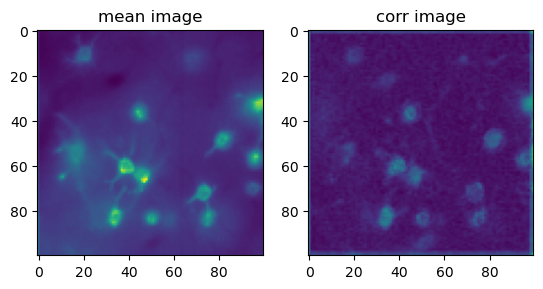

In [10]:
# Create mean and correlation images
img = mean_image(mc.mmap_file[0], window = 1000, dview=dview)
img = (img-np.mean(img))/np.std(img)

gaussian_blur = False        # Use gaussian blur when there is too much noise in the video
Cn = local_correlations_movie_offline(mc.mmap_file[0], fr=fr, window=fr*4, 
                                      stride=fr*4, winSize_baseline=fr, 
                                      remove_baseline=True, gaussian_blur=gaussian_blur,
                                      dview=dview).max(axis=0)
img_corr = (Cn-np.mean(Cn))/np.std(Cn)
summary_images = np.stack([img, img, img_corr], axis=0).astype(np.float32)
# Save summary images which are used in the VolPy GUI
cm.movie(summary_images).save(fnames[:-5] + '_summary_images.tif')
fig, axs = plt.subplots(1, 2)
axs[0].imshow(summary_images[0]); axs[1].imshow(summary_images[2])
axs[0].set_title('mean image'); axs[1].set_title('corr image')

       41138 [utils.py:      download_model():166][31434] File mask_rcnn already downloaded



Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  128
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              pad64
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE               

       43295 [deprecation.py:            new_func():545][31434] From /home/nel/anaconda3/envs/caiman_volpy_notebook/lib/python3.10/site-packages/tensorflow/python/util/deprecation.py:620: calling map_fn_v2 (from tensorflow.python.ops.map_fn) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Use fn_output_signature instead
2023-04-18 15:59:49.683110: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open /home/nel/caiman_data/model/mask_rcnn: DATA_LOSS: not an sstable (bad magic number): perhaps your file is in a different file format and you need to use a different restore operator?
2023-04-18 15:59:50.073878: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flag

Processing 1 images
image                    shape: (100, 100, 3)         min:   -1.53904  max:   12.00778  float32
molded_images            shape: (1, 128, 128, 3)      min:   -1.50889  max:    9.52473  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  128.00000  float64
anchors                  shape: (1, 4092, 4)          min:   -1.42535  max:    1.92141  float32


/home/nel/anaconda3/envs/caiman_volpy_notebook/lib/python3.10/site-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
       45373 [timeseries.py:                save():288][31434] No file saved


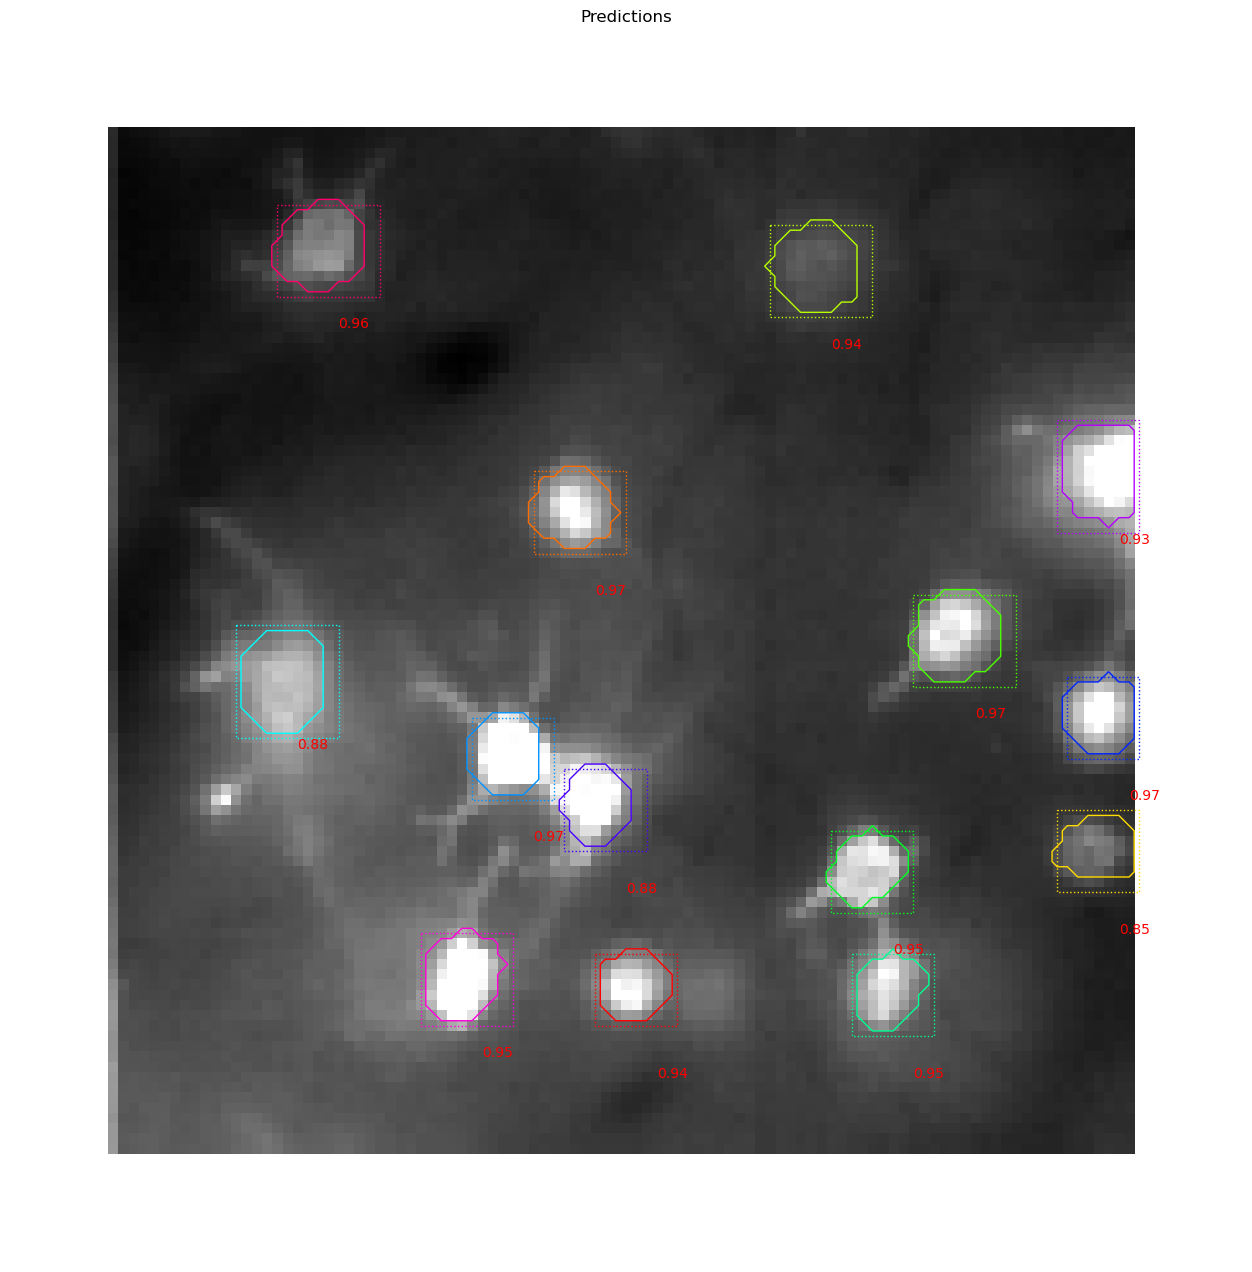

In [11]:
use_maskrcnn = True  # set to True to predict the ROIs using the mask R-CNN
if not use_maskrcnn:                 # use manual annotations
    with h5py.File(path_ROIs, 'r') as fl:
        ROIs = fl['mov'][()]  # load ROIs
else:
    weights_path = download_model('mask_rcnn')    
    ROIs = utils.mrcnn_inference(img=summary_images.transpose([1, 2, 0]), size_range=[5, 22],
                                  weights_path=weights_path, display_result=True) # size parameter decides size range of masks to be selected
    cm.movie(ROIs).save(fnames[:-5] + '_mrcnn_ROIs.hdf5')

Text(0.5, 1.0, 'masks')

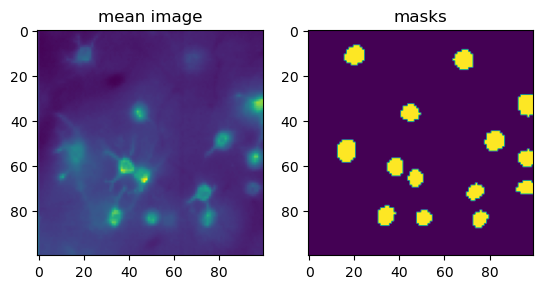

In [12]:
fig, axs = plt.subplots(1, 2)
axs[0].imshow(summary_images[0]); axs[1].imshow(ROIs.sum(0))
axs[0].set_title('mean image'); axs[1].set_title('masks')

In [13]:
# Restart cluster to clean up memory
cm.stop_server(dview=dview)
c, dview, n_processes = cm.cluster.setup_cluster(
    backend='local', n_processes=None, single_thread=False, maxtasksperchild=1)

       45835 [cluster.py:         stop_server():348][31434] stop_cluster(): done


Now processing cell number 0Now processing cell number 1Now processing cell number 2Now processing cell number 3Now processing cell number 4Now processing cell number 5Now processing cell number 6Now processing cell number 7Now processing cell number 8Now processing cell number 10Now processing cell number 9Now processing cell number 11
Now processing cell number 13





Now processing cell number 12Decode mmap filename /home/nel/caiman_data/example_movies/volpy/memmap__d1_100_d2_100_d3_1_order_C_frames_20000.mmap


Decode mmap filename /home/nel/caiman_data/example_movies/volpy/memmap__d1_100_d2_100_d3_1_order_C_frames_20000.mmapDecode mmap filename /home/nel/caiman_data/example_movies/volpy/memmap__d1_100_d2_100_d3_1_order_C_frames_20000.mmapDecode mmap filename /home/nel/caiman_data/example_movies/volpy/memmap__d1_100_d2_100_d3_1_order_C_frames_20000.mmap
Decode mmap filename /home/nel/caiman_data/example_movies/volpy/memmap__d1_100_d2_100_d3_1_order_C_frames_20000.mmapDecode mmap f

       49712 [spikepursuit.py:     adaptive_thresh():607][31809] Selecting top 100 spikes for template
       49737 [spikepursuit.py:     adaptive_thresh():607][31814] Selecting top 100 spikes for template
       51128 [spikepursuit.py:     adaptive_thresh():607][31814] Selecting top 100 spikes for template
       51420 [spikepursuit.py:     adaptive_thresh():607][31809] Selecting top 100 spikes for template
       51529 [spikepursuit.py:     adaptive_thresh():607][31810] Selecting top 100 spikes for template
       51862 [spikepursuit.py:     adaptive_thresh():607][31814] Selecting top 100 spikes for template
       52784 [spikepursuit.py:     adaptive_thresh():607][31806] Selecting top 100 spikes for template
       53228 [spikepursuit.py:     adaptive_thresh():604][31816] Few spikes were detected. Adjusting threshold to take 10 largest spikes
       53266 [spikepursuit.py:     adaptive_thresh():607][31809] Selecting top 100 spikes for template
       53285 [spikepursuit.py:     adap

## Trace denoising and spike extraction

In [14]:
# Parameters for trace denoising and spike extraction
ROIs = ROIs                                   # region of interests
index = list(range(len(ROIs)))                # index of neurons
weights = None                                # if None, use ROIs for initialization; to reuse weights check reuse weights block 

template_size = 0.02                          # half size of the window length for spike templates, default is 20 ms 
context_size = 35                             # number of pixels surrounding the ROI to censor from the background PCA
visualize_ROI = False                         # whether to visualize the region of interest inside the context region
flip_signal = True                            # Important!! Flip signal or not, True for Voltron indicator, False for others
hp_freq_pb = 1 / 3                            # parameter for high-pass filter to remove photobleaching
clip = 100                                    # maximum number of spikes to form spike template
threshold_method = 'adaptive_threshold'       # adaptive_threshold or simple 
min_spikes= 10                                # minimal spikes to be found
pnorm = 0.5                                   # a variable deciding the amount of spikes chosen for adaptive threshold method
threshold = 3                                 # threshold for finding spikes only used in simple threshold method, Increase the threshold to find less spikes
do_plot = False                               # plot detail of spikes, template for the last iteration
ridge_bg= 0.01                                # ridge regression regularizer strength for background removement, larger value specifies stronger regularization 
sub_freq = 20                                 # frequency for subthreshold extraction
weight_update = 'ridge'                       # ridge or NMF for weight update
n_iter = 2                                    # number of iterations alternating between estimating spike times and spatial filters

opts_dict={'fnames': fname_new,
            'ROIs': ROIs,
            'index': index,
            'weights': weights,
            'template_size': template_size, 
            'context_size': context_size,
            'visualize_ROI': visualize_ROI, 
            'flip_signal': flip_signal,
            'hp_freq_pb': hp_freq_pb,
            'clip': clip,
            'threshold_method': threshold_method,
            'min_spikes':min_spikes,
            'pnorm': pnorm, 
            'threshold': threshold,
            'do_plot':do_plot,
            'ridge_bg':ridge_bg,
            'sub_freq': sub_freq,
            'weight_update': weight_update,
            'n_iter': n_iter}

opts.change_params(params_dict=opts_dict);    

       46094 [volparams.py:                 set():95][31434] Changing key ROIs in group data from None to [[[False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]
  ...
  [False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]]

 [[False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]
  ...
  [False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]]

 [[False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]
  ...
  [False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]]

 ...

 [[False False False ... False False False]
  [False False False ... Fal

In [15]:
vpy = VOLPY(n_processes=n_processes, dview=dview, params=opts)
vpy.fit(n_processes=n_processes, dview=dview)

## Visualization

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]
Component:0


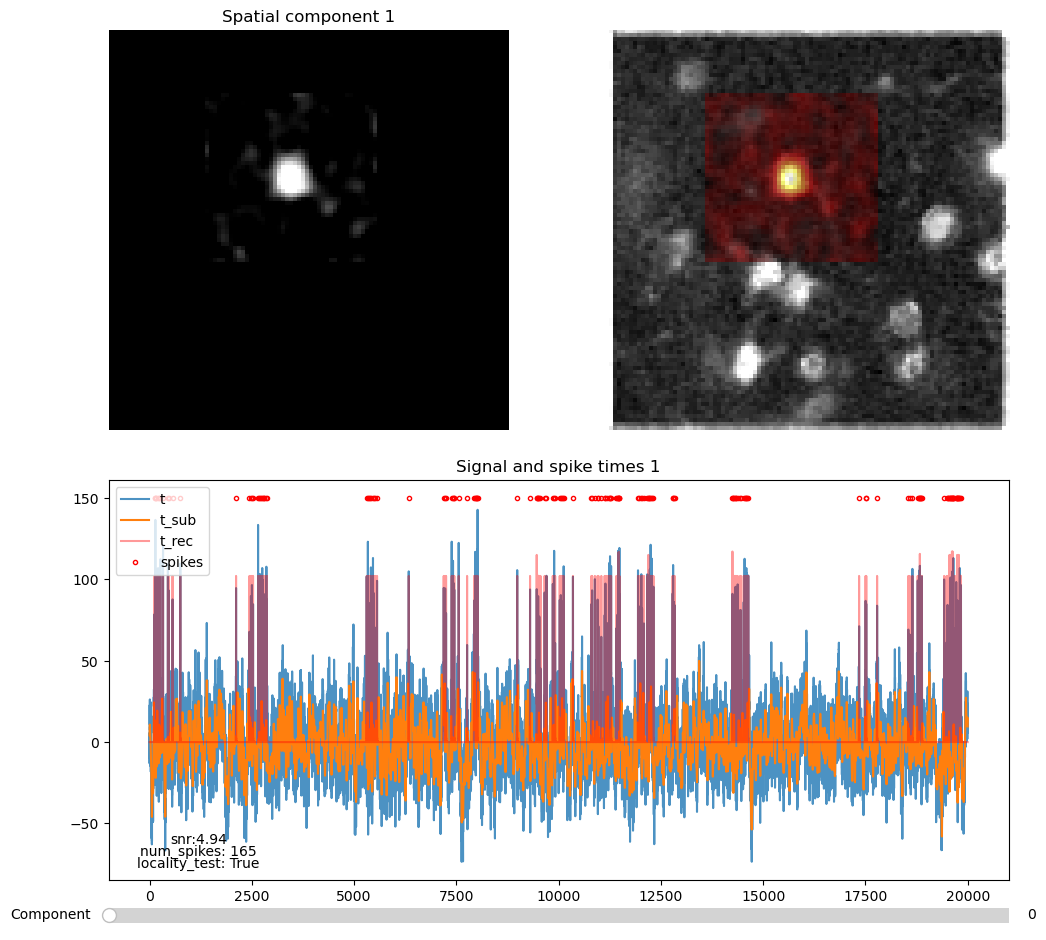

In [16]:
# Visualize spatial footprints and traces
print(np.where(vpy.estimates['locality'])[0])    # neurons that pass locality test
idx = np.where(vpy.estimates['locality'] > 0)[0]
utils.view_components(vpy.estimates, img_corr, idx)

In [17]:
# Reconstructed movie
mv_all = utils.reconstructed_movie(vpy.estimates.copy(), fnames=mc.mmap_file,
                                           idx=idx, scope=(0,1000), flip_signal=flip_signal)
mv_all.play(fr=40, magnification=3)

  0%|                                                     | 0/1 [00:00<?, ?it/s]

Decode mmap filename /home/nel/caiman_data/example_movies/volpy/demo_voltage_imaging_rig__d1_100_d2_100_d3_1_order_F_frames_20000.mmap


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.83it/s]


In [18]:
vpy.estimates['ROIs'] = ROIs
save_name = f'volpy_{os.path.split(fnames)[1][:-5]}_{threshold_method}'
np.save(os.path.join(file_dir, save_name), vpy.estimates)

In [19]:
#%% Reuse spatial weights extracted from previous video
# set weights = reuse_weights in opts_dict dictionary
if False:
    estimates = np.load(os.path.join(file_dir, save_name+'.npy'), allow_pickle=True).item()
    reuse_weights = []
    for idx in range(ROIs.shape[0]):
        coord = estimates['context_coord'][idx]
        w = estimates['weights'][idx][coord[0][0]:coord[1][0]+1, coord[0][1]:coord[1][1]+1] 
        plt.figure(); plt.imshow(w);plt.colorbar(); plt.show()
        reuse_weights.append(w)

In [20]:
# Stop cluster and clean up log files
cm.stop_server(dview=dview)
log_files = glob.glob('*_LOG_*')
for log_file in log_files:
    os.remove(log_file)

       60584 [cluster.py:         stop_server():348][31434] stop_cluster(): done
